# Lab5
Библиотеки

In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as functional
from torchvision import transforms

Импорт датасета

In [2]:
csv_path = "C:/Users/Yana/Documents/python-v6/Lab2/file.csv"
df = pd.read_csv(csv_path, delimiter=",", names=["Absolute path", "Relative path", "Tag"])
images = df["Absolute path"].to_list()
random.shuffle(images)
print(images)
img_label=[]
for i in range(len(images)):
    img_label.append(os.path.basename(os.path.dirname(images[i])))
print(img_label[:20])

['C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\1498.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\0210.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0448.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0437.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0692.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\0943.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0031.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\0718.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\1043.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\0437.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0230.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\1350.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0754.jpg', 'C:\\Users\\Yana\\Documents\\python-

Делим список изображений на тренировочный, тестовый и валидационный

In [28]:
train_list = images[0:int(len(images) * 0.8)]
test_list = images[int(len(images) * 0.8) : int(len(images) * 0.9)]
valid_list = images[int(len(images) * 0.9) : int(len(images))]

print(len(train_list), len(test_list), len(valid_list))

2403 300 301


Проверяем датасет

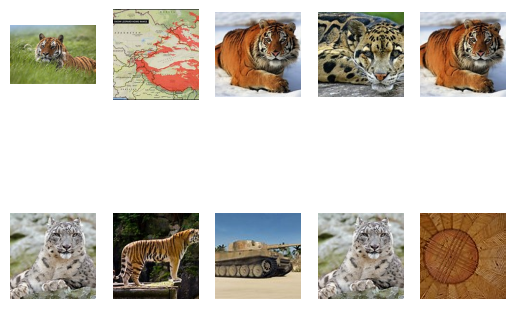

In [216]:
random_idx = np.random.randint(1,len(images),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(images[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')
    
plt.show()

Класс dataset, который хранит загруженные и преобразованные изображения

In [30]:
class dataset(torch.utils.data.Dataset):
    
    def __init__(self,dataset,transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.dataset)
        return self.filelength
    
    def __getitem__(self,index:int):
        img_label=[]
        for i in range(len(self.dataset)):
            img_label.append(os.path.basename(os.path.dirname(self.dataset[i])))
        img_path = self.dataset[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_label[index]
        if label == 'tiger':
            label=0
        elif label == 'leopard':
            label=1
        return img_transformed,label

Формируем набор данных для обучения

In [6]:

fixed_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )
train_data = dataset(train_list, transform=fixed_transforms)
test_data = dataset(test_list, transform=fixed_transforms)
val_data = dataset(valid_list, transform=fixed_transforms)
print(train_data.dataset,train_data.transform)


['C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\1498.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\0210.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0448.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0437.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0692.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\0943.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0031.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\0718.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\1043.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\0437.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0230.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\1350.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0754.jpg', 'C:\\Users\\Yana\\Documents\\python-

Строим модельку:<br>
    -3 слоя свертки и 2 полносвязных слоя;<br>
    -пакетная нормализация для ограничения переобучения;

In [7]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = output.view(output.size(0),-1)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)
        return output

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
    
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

Рисуем графики

In [9]:
def draw_results(epochs, acc, loss, v_acc, v_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(epochs), acc, color="orange", label="Train accuracy")
    ax2.plot(range(epochs), loss, color="orange", label="Train loss")
    ax1.plot(range(epochs), v_acc, color="steelblue", label="Validation accuracy")
    ax2.plot(range(epochs), v_loss, color="steelblue", label="Validation loss")
    ax1.legend()
    ax2.legend()
    plt.show() 

Цикл обучения

In [10]:
def train_loop(epochs, batch_size, lear):
    optimizer = optim.Adam(params = model.parameters(),lr=lear)
    criterion = nn.CrossEntropyLoss()
    epochs = epochs
    accuracy_values = []
    loss_values = []
    val_accuracy_values=[]
    val_loss_values=[]
    val_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                            batch_size=batch_size, 
                                            shuffle=False)
    train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                            batch_size=batch_size, 
                                            shuffle=True )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())

        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)
                
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            val_accuracy_values.append(epoch_val_accuracy.item())
            val_loss_values.append(epoch_val_loss.item()) 
    draw_results(epochs,accuracy_values, loss_values, val_accuracy_values, val_loss_values)

Запускаем обучение

Epoch : 1, train accuracy : 0.7093333005905151, train loss : 0.5481065511703491
Epoch : 1, val_accuracy : 0.8460000157356262, val_loss : 0.3822340965270996
Epoch : 2, train accuracy : 0.8622667193412781, train loss : 0.34449502825737
Epoch : 2, val_accuracy : 0.8880000114440918, val_loss : 0.3128696084022522
Epoch : 3, train accuracy : 0.8834667205810547, train loss : 0.30623558163642883
Epoch : 3, val_accuracy : 0.8939999938011169, val_loss : 0.25556790828704834
Epoch : 4, train accuracy : 0.9107999801635742, train loss : 0.24584747850894928
Epoch : 4, val_accuracy : 0.921999990940094, val_loss : 0.2397368997335434
Epoch : 5, train accuracy : 0.9186665415763855, train loss : 0.19796068966388702
Epoch : 5, val_accuracy : 0.9080000519752502, val_loss : 0.2075674831867218
Epoch : 6, train accuracy : 0.9215999841690063, train loss : 0.20284369587898254
Epoch : 6, val_accuracy : 0.9120000004768372, val_loss : 0.19073253870010376
Epoch : 7, train accuracy : 0.9021332859992981, train loss : 

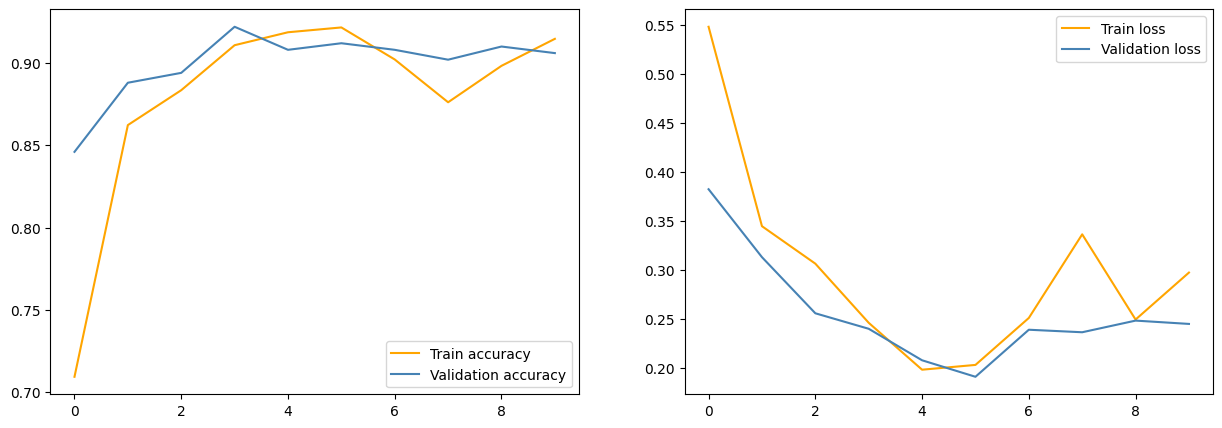

In [251]:
train_loop(10, 100, 0.001)

Epoch : 1, train accuracy : 0.9373076558113098, train loss : 0.16945597529411316
Epoch : 1, val_accuracy : 0.9300000071525574, val_loss : 0.21082618832588196
Epoch : 2, train accuracy : 0.9185898303985596, train loss : 0.19434002041816711
Epoch : 2, val_accuracy : 0.925000011920929, val_loss : 0.20237091183662415
Epoch : 3, train accuracy : 0.9361538887023926, train loss : 0.18572461605072021
Epoch : 3, val_accuracy : 0.9200000166893005, val_loss : 0.2413311004638672
Epoch : 4, train accuracy : 0.9135896563529968, train loss : 0.22774174809455872
Epoch : 4, val_accuracy : 0.9233333468437195, val_loss : 0.18817785382270813
Epoch : 5, train accuracy : 0.9005127549171448, train loss : 0.2054327130317688
Epoch : 5, val_accuracy : 0.9116666316986084, val_loss : 0.22718214988708496
Epoch : 6, train accuracy : 0.9473077654838562, train loss : 0.14366590976715088
Epoch : 6, val_accuracy : 0.9100000262260437, val_loss : 0.2172841727733612
Epoch : 7, train accuracy : 0.9262819886207581, train lo

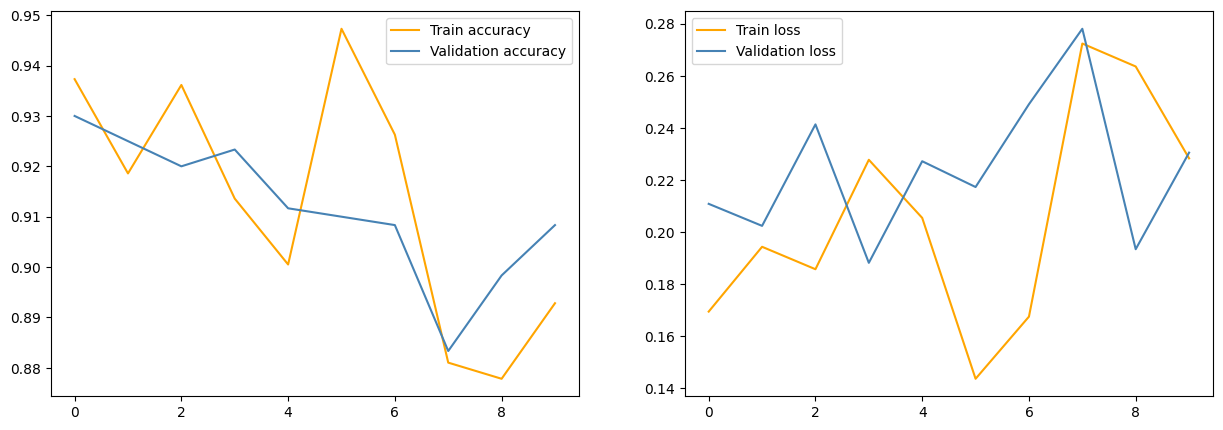

In [252]:
train_loop(10, 200, 0.001)

Epoch : 1, train accuracy : 0.9470370411872864, train loss : 0.14047908782958984
Epoch : 1, val_accuracy : 0.9116666913032532, val_loss : 0.24352332949638367
Epoch : 2, train accuracy : 0.9522222876548767, train loss : 0.13204771280288696
Epoch : 2, val_accuracy : 0.9383333921432495, val_loss : 0.15625546872615814
Epoch : 3, train accuracy : 0.9503703713417053, train loss : 0.12385710328817368
Epoch : 3, val_accuracy : 0.9383333921432495, val_loss : 0.18514782190322876
Epoch : 4, train accuracy : 0.9262963533401489, train loss : 0.24274468421936035
Epoch : 4, val_accuracy : 0.9333333969116211, val_loss : 0.16661383211612701
Epoch : 5, train accuracy : 0.9040741324424744, train loss : 0.30556678771972656
Epoch : 5, val_accuracy : 0.9300000667572021, val_loss : 0.20633292198181152
Epoch : 6, train accuracy : 0.8896296620368958, train loss : 0.2963084280490875
Epoch : 6, val_accuracy : 0.8916666507720947, val_loss : 0.2225225865840912
Epoch : 7, train accuracy : 0.9185184836387634, train 

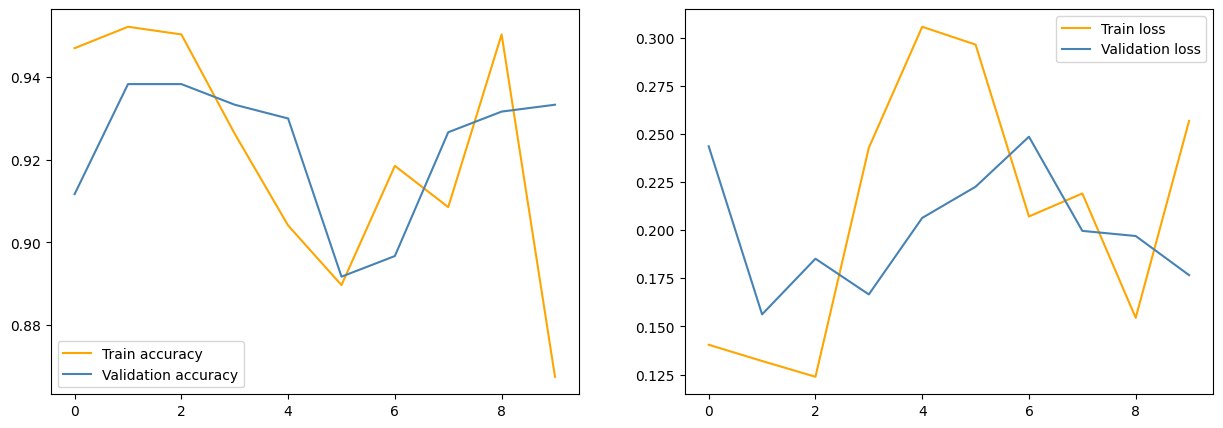

In [253]:
train_loop(10, 300, 0.001)

Epoch : 1, train accuracy : 0.7086666822433472, train loss : 0.5980064868927002
Epoch : 1, val_accuracy : 0.7320000529289246, val_loss : 0.5370778441429138
Epoch : 2, train accuracy : 0.7759999632835388, train loss : 0.5269773006439209
Epoch : 2, val_accuracy : 0.7800000309944153, val_loss : 0.50234055519104
Epoch : 3, train accuracy : 0.7978666424751282, train loss : 0.4900408387184143
Epoch : 3, val_accuracy : 0.7879999876022339, val_loss : 0.4879606068134308
Epoch : 4, train accuracy : 0.7934665679931641, train loss : 0.4808523952960968
Epoch : 4, val_accuracy : 0.8299999833106995, val_loss : 0.4303276538848877
Epoch : 5, train accuracy : 0.83653324842453, train loss : 0.4368158280849457
Epoch : 5, val_accuracy : 0.7459999918937683, val_loss : 0.5049601793289185
Epoch : 6, train accuracy : 0.7561331987380981, train loss : 0.5226154327392578
Epoch : 6, val_accuracy : 0.8300000429153442, val_loss : 0.42875170707702637
Epoch : 7, train accuracy : 0.8439999222755432, train loss : 0.4090

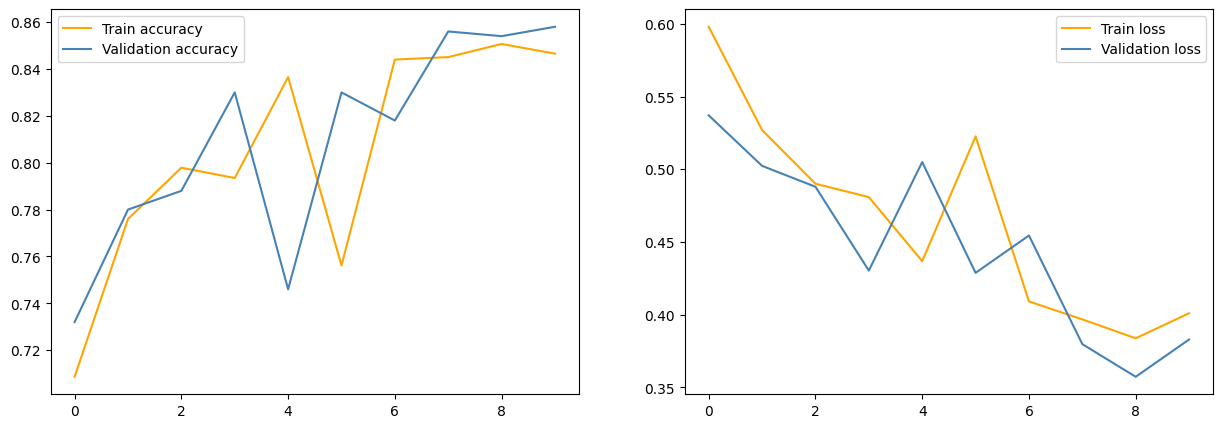

In [11]:
train_loop(10, 100, 0.005)

Epoch : 1, train accuracy : 0.8749999403953552, train loss : 0.3397578299045563
Epoch : 1, val_accuracy : 0.8766667246818542, val_loss : 0.3430403470993042
Epoch : 2, train accuracy : 0.8765384554862976, train loss : 0.34497368335723877
Epoch : 2, val_accuracy : 0.8766667246818542, val_loss : 0.32849857211112976
Epoch : 3, train accuracy : 0.8321794867515564, train loss : 0.40704554319381714
Epoch : 3, val_accuracy : 0.8850000500679016, val_loss : 0.30522048473358154
Epoch : 4, train accuracy : 0.88692307472229, train loss : 0.3111898601055145
Epoch : 4, val_accuracy : 0.8800000548362732, val_loss : 0.3102719187736511
Epoch : 5, train accuracy : 0.9100000262260437, train loss : 0.2804137170314789
Epoch : 5, val_accuracy : 0.8966667056083679, val_loss : 0.2975711524486542
Epoch : 6, train accuracy : 0.9153846502304077, train loss : 0.25377780199050903
Epoch : 6, val_accuracy : 0.9016667008399963, val_loss : 0.26430025696754456
Epoch : 7, train accuracy : 0.916538417339325, train loss : 

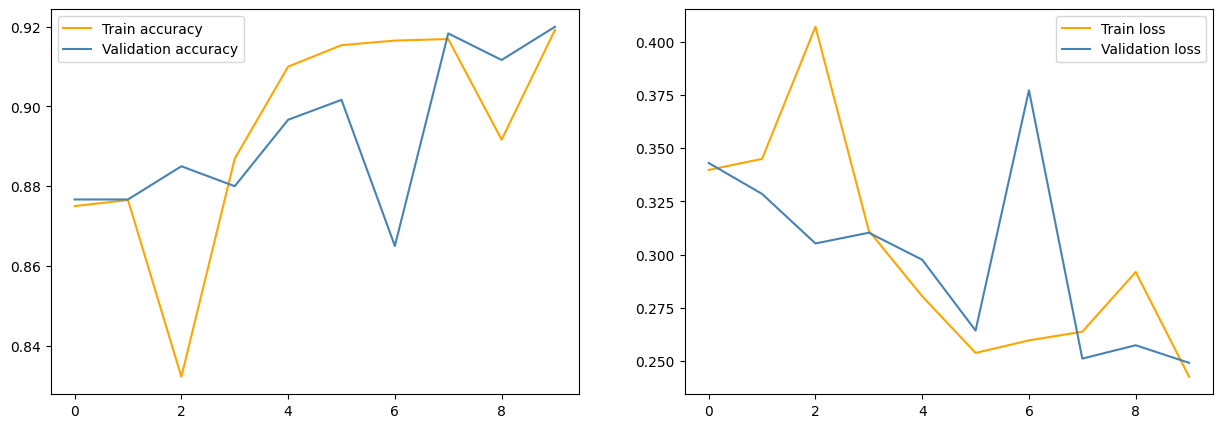

In [12]:
train_loop(10, 200, 0.005)

Epoch : 1, train accuracy : 0.852222204208374, train loss : 0.37987756729125977
Epoch : 1, val_accuracy : 0.8799999952316284, val_loss : 0.3047550320625305
Epoch : 2, train accuracy : 0.932962954044342, train loss : 0.2281273603439331
Epoch : 2, val_accuracy : 0.9166666865348816, val_loss : 0.2369961440563202
Epoch : 3, train accuracy : 0.9288889169692993, train loss : 0.22564814984798431
Epoch : 3, val_accuracy : 0.9166666865348816, val_loss : 0.2604585886001587
Epoch : 4, train accuracy : 0.9329630136489868, train loss : 0.21172989904880524
Epoch : 4, val_accuracy : 0.9150000214576721, val_loss : 0.25237035751342773
Epoch : 5, train accuracy : 0.9333333969116211, train loss : 0.21191300451755524
Epoch : 5, val_accuracy : 0.9233333468437195, val_loss : 0.24962997436523438
Epoch : 6, train accuracy : 0.9281481504440308, train loss : 0.2186594307422638
Epoch : 6, val_accuracy : 0.9233333468437195, val_loss : 0.22757720947265625
Epoch : 7, train accuracy : 0.9225926995277405, train loss 

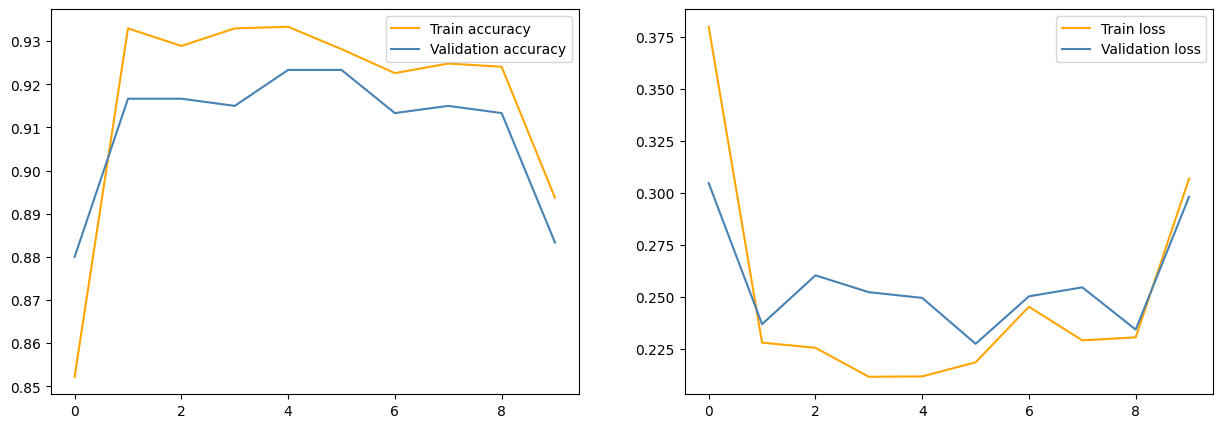

In [13]:
train_loop(10, 300, 0.005)

Epoch : 1, train accuracy : 0.8059999346733093, train loss : 0.5302457809448242
Epoch : 1, val_accuracy : 0.8339999914169312, val_loss : 0.43282413482666016
Epoch : 2, train accuracy : 0.8583999276161194, train loss : 0.3909052312374115
Epoch : 2, val_accuracy : 0.8619999885559082, val_loss : 0.360403448343277
Epoch : 3, train accuracy : 0.8735998868942261, train loss : 0.34008100628852844
Epoch : 3, val_accuracy : 0.8519999980926514, val_loss : 0.3718411922454834
Epoch : 4, train accuracy : 0.8807998895645142, train loss : 0.3238704800605774
Epoch : 4, val_accuracy : 0.8840000033378601, val_loss : 0.3272199332714081
Epoch : 5, train accuracy : 0.9091999530792236, train loss : 0.2567063570022583
Epoch : 5, val_accuracy : 0.8859999775886536, val_loss : 0.2757631540298462
Epoch : 6, train accuracy : 0.9010666608810425, train loss : 0.2725193500518799
Epoch : 6, val_accuracy : 0.9100000262260437, val_loss : 0.24870315194129944
Epoch : 7, train accuracy : 0.8935999274253845, train loss : 0

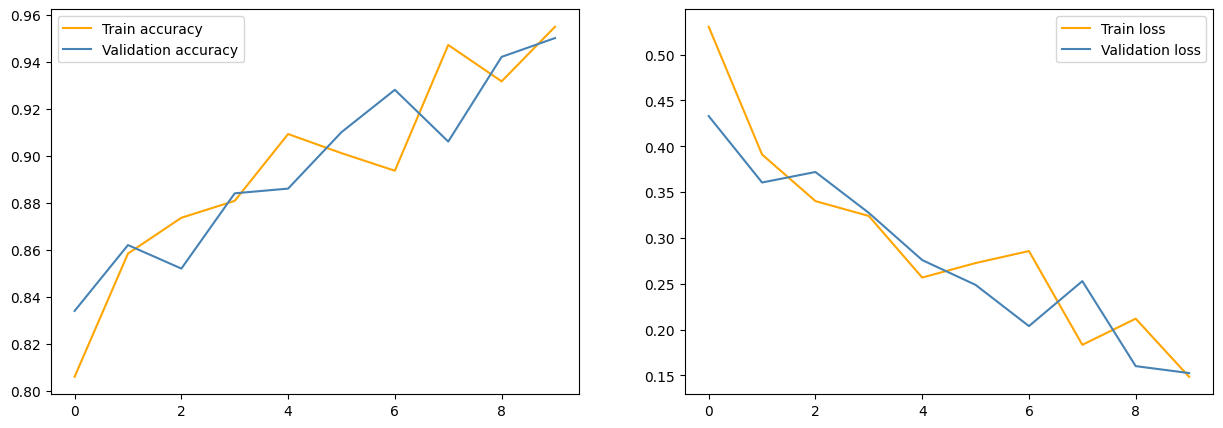

In [53]:
train_loop(10, 100, 0.007)

Epoch : 1, train accuracy : 0.9376922845840454, train loss : 0.1863665133714676
Epoch : 1, val_accuracy : 0.9466666579246521, val_loss : 0.16629648208618164
Epoch : 2, train accuracy : 0.9534614682197571, train loss : 0.1389339119195938
Epoch : 2, val_accuracy : 0.9300000071525574, val_loss : 0.20936375856399536
Epoch : 3, train accuracy : 0.9588462114334106, train loss : 0.12834587693214417
Epoch : 3, val_accuracy : 0.9599999785423279, val_loss : 0.11117559671401978
Epoch : 4, train accuracy : 0.9661539196968079, train loss : 0.10986623913049698
Epoch : 4, val_accuracy : 0.9583333134651184, val_loss : 0.12632206082344055
Epoch : 5, train accuracy : 0.9707692265510559, train loss : 0.10295729339122772
Epoch : 5, val_accuracy : 0.949999988079071, val_loss : 0.15350079536437988
Epoch : 6, train accuracy : 0.9665384292602539, train loss : 0.099341481924057
Epoch : 6, val_accuracy : 0.9416666626930237, val_loss : 0.14264175295829773
Epoch : 7, train accuracy : 0.9719230532646179, train los

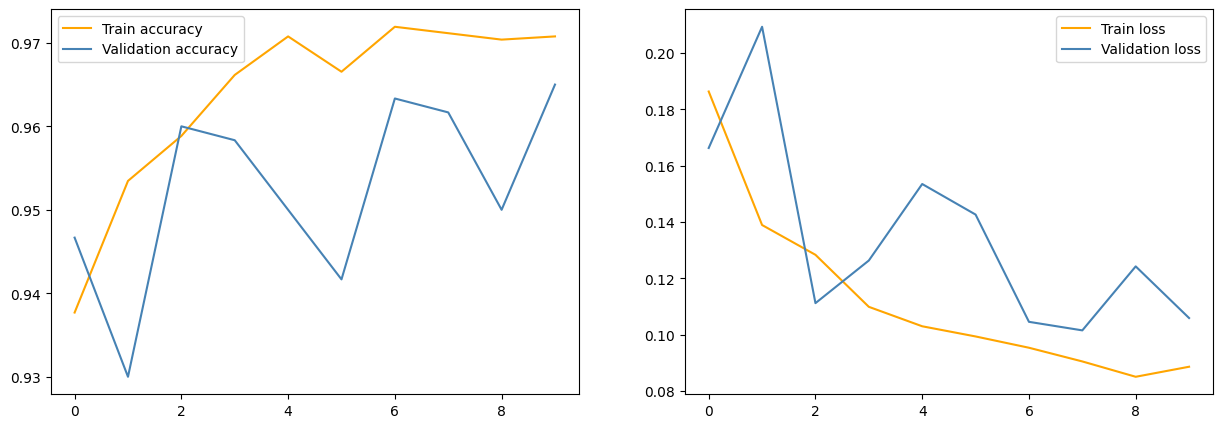

In [54]:
train_loop(10, 200, 0.007)

Epoch : 1, train accuracy : 0.9059524536132812, train loss : 0.24994182586669922
Epoch : 1, val_accuracy : 0.7612500190734863, val_loss : 0.6634498238563538
Epoch : 2, train accuracy : 0.9314286112785339, train loss : 0.19457626342773438
Epoch : 2, val_accuracy : 0.9524999856948853, val_loss : 0.1628440022468567
Epoch : 3, train accuracy : 0.9578571915626526, train loss : 0.12855125963687897
Epoch : 3, val_accuracy : 0.9512499570846558, val_loss : 0.13926565647125244
Epoch : 4, train accuracy : 0.9539285898208618, train loss : 0.1417694389820099
Epoch : 4, val_accuracy : 0.9674999713897705, val_loss : 0.11020532995462418
Epoch : 5, train accuracy : 0.9166666865348816, train loss : 0.2734132409095764
Epoch : 5, val_accuracy : 0.9249999523162842, val_loss : 0.2130657434463501
Epoch : 6, train accuracy : 0.966785728931427, train loss : 0.10384184122085571
Epoch : 6, val_accuracy : 0.966249942779541, val_loss : 0.09974127262830734
Epoch : 7, train accuracy : 0.9750000238418579, train loss 

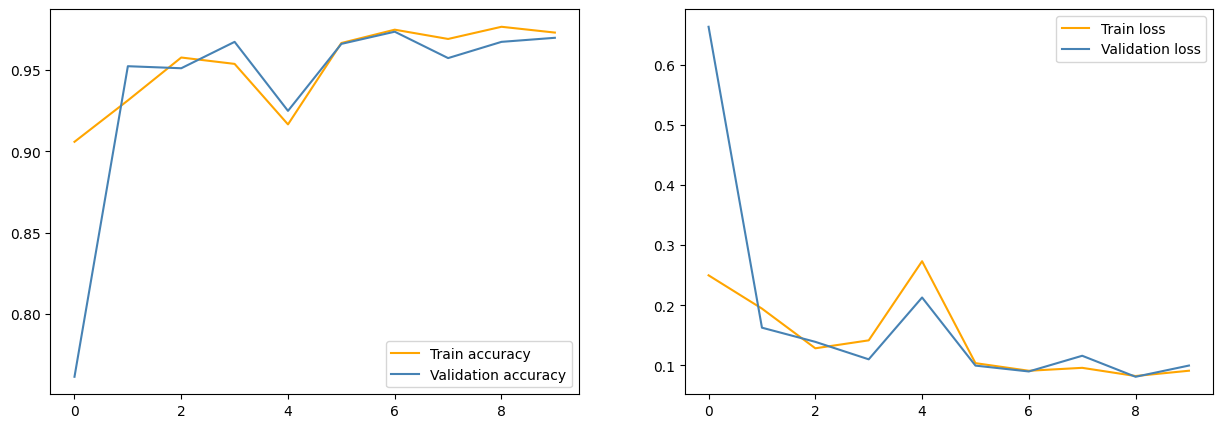

In [55]:
train_loop(10, 400, 0.007)

Картинки в датасете весьма неудачные. Даже почистив, осталось очень много копий + часть картинок являются мусорными, от них нет пользы. Более того, они засоряют обучение, снижая точность. По графику могу сказать, что точность валидационной выборки, как правило, была ниже, чем тестовой. При увеличении размера мини - пакета разница в точности между обучающей и валидационной выборкой становилась меньше. Но где-то валидационная выборка была точнее, вероятно получилось больше оригинальных картинок и получилось выявить больше признаков изображений, которые были до этого.

Записываем полученные результаты

In [56]:
tiger_probs = []
model.eval()
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=100, shuffle=False
)
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = functional.softmax(preds, dim=1)[:, 1].tolist()
        tiger_probs += list(zip(list(fileid), preds_list))
tiger_probs.sort(key=lambda x: int(x[0]))
tiger_probs[17:24]

[(tensor(0), 0.03051307052373886),
 (tensor(0), 0.9194216132164001),
 (tensor(0), 0.03051307052373886),
 (tensor(0), 0.03051307052373886),
 (tensor(0), 0.3177822530269623),
 (tensor(0), 0.03051307052373886),
 (tensor(0), 0.03051307052373886)]

In [57]:
idx = list(i for i in range(len(tiger_probs)))
prob = list(map(lambda x: x[1],tiger_probs))
submission = pd.DataFrame({'id':idx,'label':prob})
submission.to_csv('result.csv',index=False)
submission

,id,label
0,0,0.030513
1,1,0.030513
2,2,0.030513
3,3,0.188559
4,4,0.030513
...,...,...
295,295,0.998191
296,296,0.874507
297,297,0.999991
298,298,0.985187


Сохраняем модель

In [58]:
name_model = "model.pt"
torch.save(model.state_dict(), os.path.join("C:/Users/Yana/Documents/python-v6/Lab5", name_model))

Инициаизируем модель и проверяем ее на работоспособность

In [59]:
re_model = Cnn()
re_model.load_state_dict(torch.load(os.path.join("C:/Users/Yana/Documents/python-v6/Lab5", name_model)))

<All keys matched successfully>

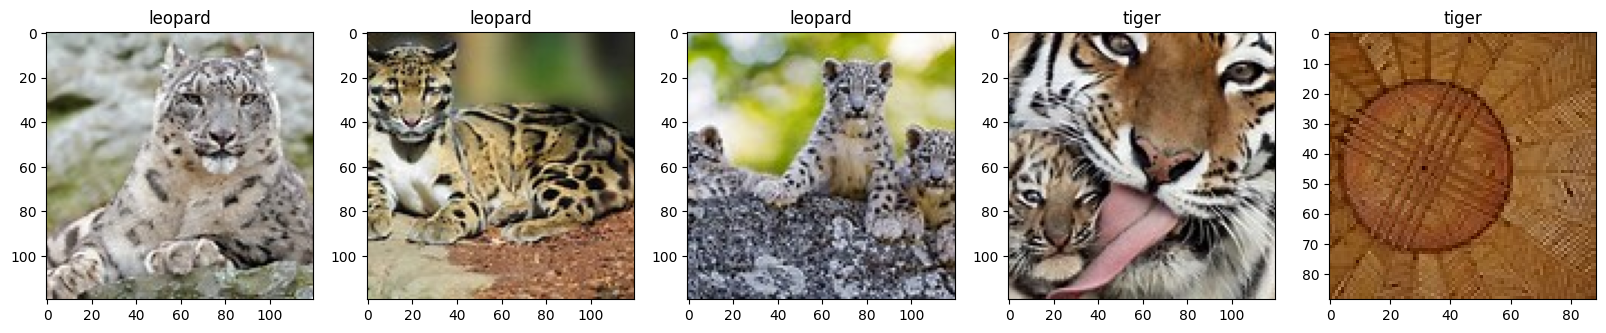

In [147]:
id_list = []

class_ = {0: 'tiger', 1: 'leopard'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = train_list[i]
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)
